In [3]:
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_dir='/content/drive/My Drive/AI/FruitinAmazon/train'
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [5]:
from PIL import Image, UnidentifiedImageError

corrupted_images = [] # List to store corrupted images path

# Loop through each class folder and check for corrupted images
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path): # Ensure it’s a valid directory
    images = os.listdir(class_path)
    for img_name in images:
      img_path = os.path.join(class_path, img_name)
      try:
        with Image.open(img_path) as img:
          img.verify() # Verify image integrity
      except (IOError, UnidentifiedImageError):
        corrupted_images.append(img_path)
# Print results
if corrupted_images:
  print("\nCorrupted Images Found:")
  for img in corrupted_images:
    print(img)
else:
  print("\nNo corrupted images found.")




No corrupted images found.


## Class Imbalance Checking

In [6]:
# Dictionary to store class counts
class_counts = {}
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images) # Count images in each class

# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


In [7]:
import random
selected_images = [] # Store image paths
selected_labels = [] # Store corresponding class names

for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images: # Ensure the class folder is not empty
      selected_img = os.path.join(class_path, random.choice(images))
      selected_images.append(selected_img)
      selected_labels.append(class_name)

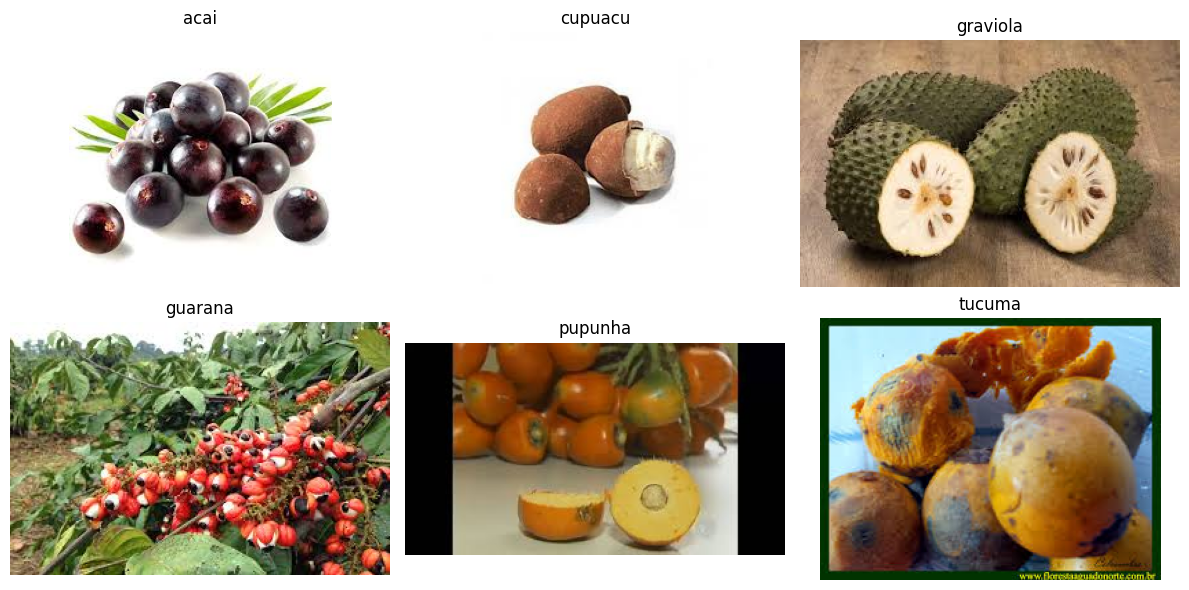

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Determine grid size
num_classes = len(selected_images)
cols = (num_classes + 1) // 2 # Determine columns
rows = 2 # Fixed rows for layout
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
  if i < num_classes:
    img = mpimg.imread(selected_images[i])
    ax.imshow(img)
    ax.set_title(selected_labels[i])
    ax.axis("off")
  else:
    ax.axis("off") # Hide empty subplots

plt.tight_layout()
plt.show()

In [9]:
import keras

image_size = (28, 28)
batch_size = 32
train_ds, val_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="both",
  seed=1337,
  image_size=image_size,
  batch_size=batch_size,
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


In [10]:
for images, labels in train_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)

Images shape: (32, 28, 28, 3)
Labels shape: (32,)


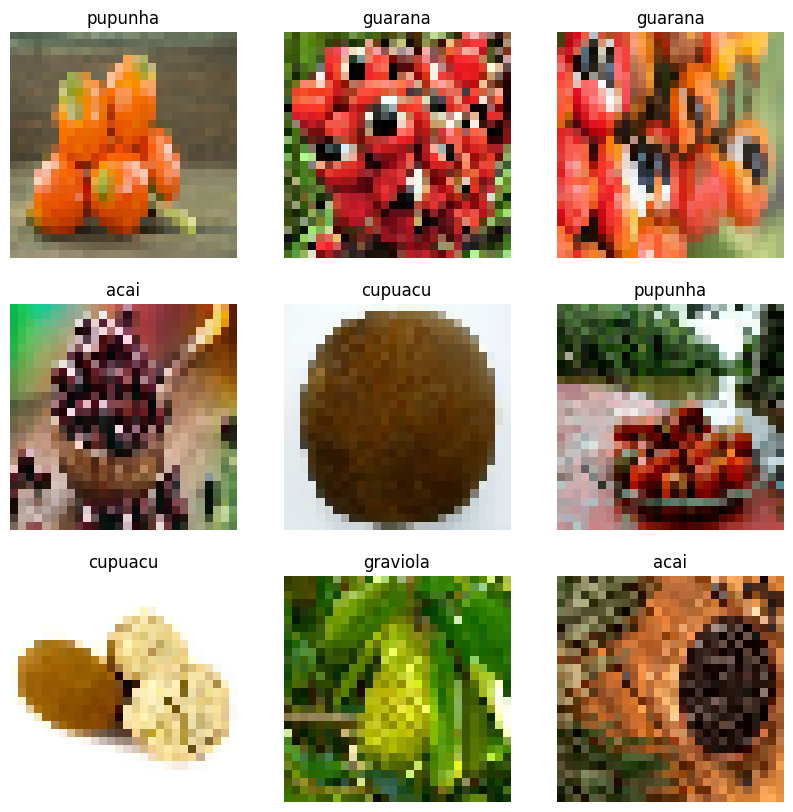

In [11]:
import numpy as np

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  # Takes one batch of images from the dataset (train_ds):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

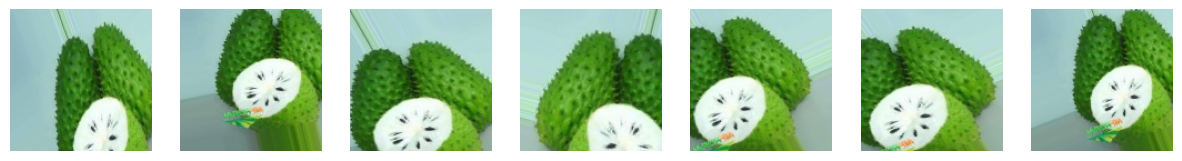

In [12]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  rotation_range=30, # Rotate images by up to 30 degrees
  width_shift_range=0.2, # Shift width by 20%
  height_shift_range=0.2, # Shift height by 20%
  shear_range=0.2, # Shear transformation
  zoom_range=0.2, # Zoom in/out by 20%
  horizontal_flip=True, # Flip images horizontally
  fill_mode='nearest' # Fill in missing pixels
)

# Load an example image
from tensorflow.keras.preprocessing import image

image_direct ='/content/drive/My Drive/AI/FruitinAmazon/train/graviola/images (3).jpeg'

img = image.load_img(image_direct, target_size=(128, 128))
x = image.img_to_array(img) # Convert to NumPy array
x = np.expand_dims(x, axis=0)

# Generate augmented images
aug_iter = datagen.flow(x, batch_size=1)

# Visualize 7 augmented images
fig, ax = plt.subplots(1, 7, figsize=(15, 5))
for i in range(7):
  batch = next(aug_iter)
  ax[i].imshow(batch[0].astype('uint8'))
  ax[i].axis('off')
plt.show()

In [13]:
from tensorflow.keras import layers as layers

data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  ]
def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

In [14]:
model = keras.Sequential([
  layers.Input(shape=(128, 128, 3)),
  *data_augmentation_layers, # Include augmentation before the model layers
  layers.Conv2D(32, (3,3), activation="relu"),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(10, activation="softmax")
])

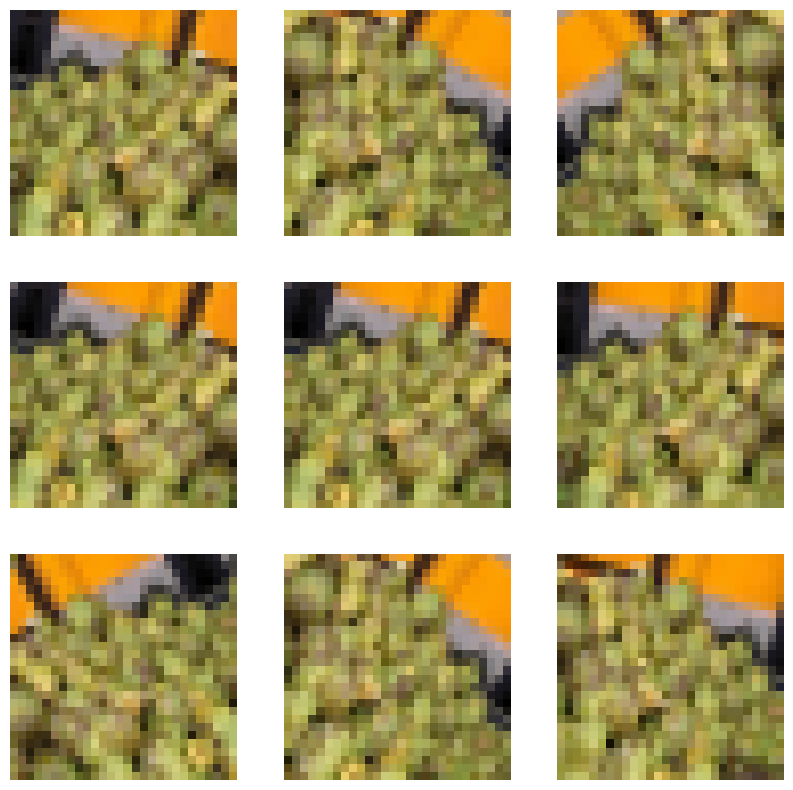

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(augmented_images[0]).astype("uint8"))
    plt.axis("off")

In [16]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [17]:
# Converting the Dataset to GreyScale
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(28, 28),
    color_mode='grayscale',  # Convert to grayscale
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(28, 28),
    color_mode='grayscale',  # Convert to grayscale
    batch_size=32
)

Found 90 files belonging to 6 classes.
Found 90 files belonging to 6 classes.


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.0852 - loss: 41.1824 - val_accuracy: 0.2222 - val_loss: 22.6818
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.2182 - loss: 22.4715 - val_accuracy: 0.2222 - val_loss: 12.2615
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.3007 - loss: 11.4064 - val_accuracy: 0.2889 - val_loss: 8.3012
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.2783 - loss: 8.0022 - val_accuracy: 0.4444 - val_loss: 4.6795
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.4733 - loss: 4.0339 - val_accuracy: 0.4889 - val_loss: 1.9265
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4554 - loss: 1.9693
Test accuracy: 0.4889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted class names:
cupuacu
cupuacu
cupuacu
tucuma
cupuacu


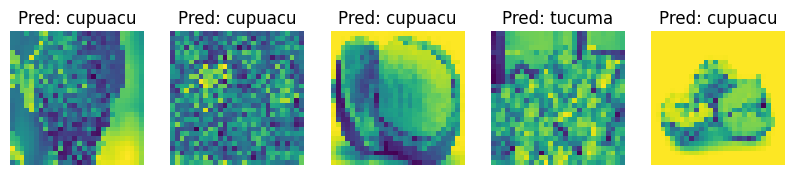

In [20]:
# Define a simple CNN model
model = keras.Sequential([
  layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation="relu"),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(10, activation="softmax") # 10 classes for MNIST digits
])

# Compile the model
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

# Train the model
model.fit(train_ds, epochs=5, batch_size=32, validation_data=val_ds)
# Evaluate the model
test_loss, test_acc = model.evaluate(train_ds)
print(f"Test accuracy: {test_acc:.4f}")
# Make predictions
# predictions = model.predict(x_test[:5])
# predicted_labels = np.argmax(predictions, axis=1)
# print("Predicted labels:", predicted_labels)

# Get the class names from the dataset
class_names = val_ds.class_names

# Make predictions and print class names
for images, labels in val_ds.take(1):  # Take one batch from the validation dataset
    predictions = model.predict(images[:5])  # Predict for the first 5 images
    predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the highest probability for each image

    # Print predicted class names
    print("Predicted class names:")
    for label in predicted_labels:
        print(class_names[label])  # Print the class name instead of the label number

    # Optionally, show the images with their predictions
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[predicted_labels[i]]}")
        plt.axis("off")
    plt.show()


In [21]:
data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
]

In [22]:
def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

In [23]:
from tensorflow.keras import layers, Sequential

model = Sequential([
    # Data augmentation applied using Lambda layer
    layers.Lambda(data_augmentation, input_shape=(224, 224, 3)),
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Fourth Convolutional Block
    layers.Conv2D(256, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Flatten the output of the last Conv2D layer
    layers.Flatten(),
    # First Fully Connected Layer
    layers.Dense(512, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    # Second Fully Connected Layer
    layers.Dense(256, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    # Third Fully Connected Layer
    layers.Dense(128, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    # Fourth Fully Connected Layer
    layers.Dense(64, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    # Output Layer with 10 neurons (for classification task with 10 classes)
    layers.Dense(10, activation='softmax')
])

# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy as the metric
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,257,930 (100.17 MB)

 Trainable params: 26,255,050 (100.16 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [24]:
from tensorflow.keras.applications import VGG16
# Load the VGG16 model pre-trained on ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
# Freeze the layers of the base model
for layer in base_model.layers:
  layer.trainable = False

In [35]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensions (height, width) to a single vector per image
x = Dense(1024, activation='relu')(x) # Fully connected layer with 1024 neurons
x = Dense(10, activation='softmax')(x) # Output layer for 10 classes (with softmax for multi-classclassification)

In [36]:
from tensorflow.keras.models import Model
# Create the final model
model = Model(inputs=base_model.input, outputs=x)

In [40]:
from tensorflow.keras.optimizers import Adam
# Compile the model

train_ds, val_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="both",
  seed=1337,
  image_size=(224,224),
  batch_size=32,
)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, epochs=5, validation_data=val_ds)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 16s/step - accuracy: 0.0790 - loss: 9.8329 - val_accuracy: 0.1111 - val_loss: 9.8347
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 76s 15s/step - accuracy: 0.4991 - loss: 2.6727 - val_accuracy: 0.3333 - val_loss: 4.3861
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 83s 16s/step - accuracy: 0.9301 - loss: 0.2382 - val_accuracy: 0.5556 - val_loss: 4.3186
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 16s/step - accuracy: 0.9271 - loss: 0.3016 - val_accuracy: 0.4444 - val_loss: 5.3833
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 16s/step - accuracy: 0.9813 - loss: 0.0625 - val_accuracy: 0.4444 - val_loss: 6.0743


In [41]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1024)                │         525,3

 Total params: 16,321,376 (62.26 MB)

 Trainable params: 535,562 (2.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,071,126 (4.09 MB)